# Discrete Fourier Transform and Lomb-Scargle Periodogram

Fourier analysis is the method of representing or approximating general functions using a sum of periodic trigonometric functions. Fourier transform is a mathematical transform that decomposes a signal, which is a time dependent function, into functions of temporal frequency, thus allowing the calculation of the periodicity of the signal. The Fourier decomposition of function f(t) is:
\begin{equation}
f(t)=\frac{\alpha_o}{2} + \sum_{n=1}^{\infty} (\alpha_n \cdot cos(n\omega t ) +b_n \cdot sin(n \omega t))
\end{equation}
where a and b are complex values that represent the signal.

Fourier transform is one of the most used methods implemented in order to search for periodic signals in astronomical  observations. It can even represent non periodic signals with high accuracy when the data are evenly spaced, but can give results even in cases when the data are not evenly spaced, but with lower accuracy.

The Lomb-Scargle Periodogram is an algorithm that can detect periodicity in unevenly spaced data. The function modeling the signal based on the periodogram is:
\begin{equation}
d(t_i)=A cos(2\pi ft_i - \theta) + B sin(2 \pi ft_i - \theta) +n
\end{equation}
where d is the data in time, A and B are the amplitudes of the trigonometric functions that describe the signal, f is the frequency, n is the noise, and θ is a phase that is used to orthogonize the trigonometric expression in case of uneven data. The phase θ is given by the equation:
\begin{equation}
\theta = \frac{1}{2} arctan \left(\sum_{i=1}^{N} sin(4\pi ft_i), \sum_{i=1}^{N} cos(4\pi ft_i) \right)
\end{equation}
The power spectral density of the periodogram is given by:
\begin{equation}
P(\omega)=\frac{1}{2\sigma^2} \left(\frac{R(\omega)^2}{C(\omega)} + \frac{I(\omega)^2}{S(\omega)} \right) 
\end{equation}
where:
\begin{equation}
R(\omega)=\sum_{i=1}^{N} d(t_i) cos(2\pi t_i - \theta)
\end{equation}
\begin{equation}
I(\omega)=\sum_{i=1}^{N} d(t_i) sin(2\pi t_i - \theta)
\end{equation}
\begin{equation}
C(\omega)=\sum_{i=1}^{N} cos^2 (2\pi t_i - \theta)
\end{equation}
\begin{equation}
S(\omega)=\sum_{i=1}^{N} sin^2 (2\pi t_i - \theta)
\end{equation}
and σ^2 is the variance of the data.

In order to calculate the confidence level, we can calculate thresholds based on the distribution of the FFT magnitudes and the Lomb-Scargle powers these significance levels correspond to the percentile values of the power distribution under the null hypothesis (random noise). We will set 3 different confidence level, 99% significance, 95% significance and 68% significance.

At first we set up the needed libraries and we created the function to estimate the noise level of our data.

In [1]:
import matplotlib.pyplot as plt #Library for plots
import numpy as np #Library for scientific computing
from astropy.timeseries import LombScargle #Library for statistics - Lomb-Scragle periodogram

### Uploading the data

In [2]:
data=np.loadtxt("synthetic_data_2.txt", skiprows=1, usecols=(0, 2)) #Loading data from ASCII file and keeping only the necessary columns
flux = data[:,1] #flux data 
JD = data[:,0] #time data as Julian Date

Plotting the data.

Text(0, 0.5, 'Normalized Flux')

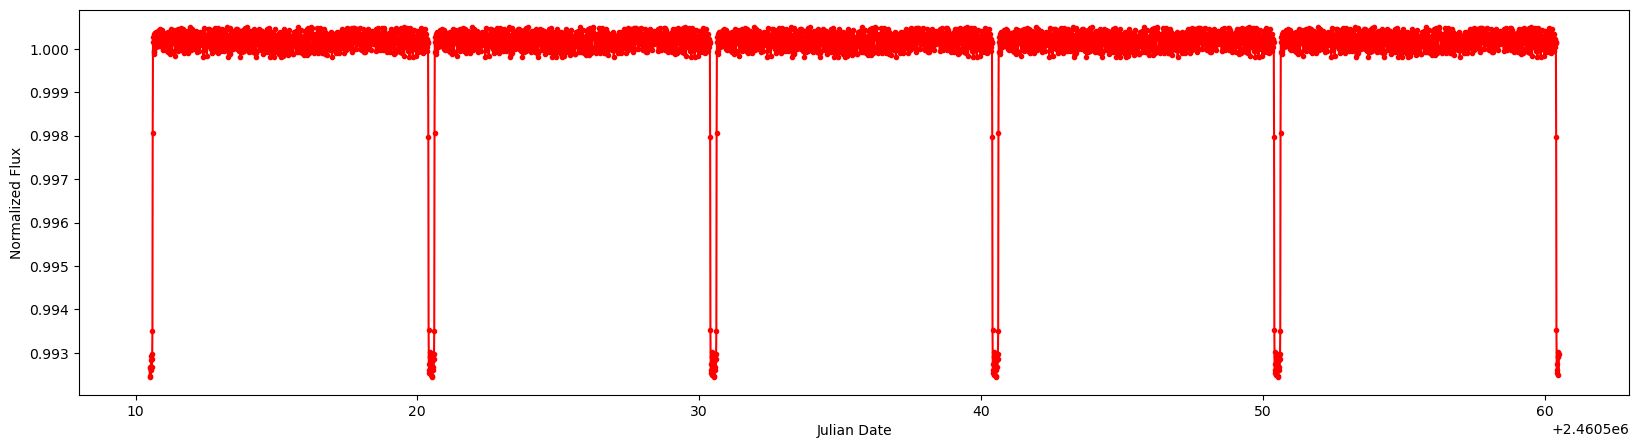

In [3]:
plt.figure(figsize=(20,5))
plt.plot(JD, flux,".-", color='r')
plt.xlabel("Julian Date")
plt.ylabel("Normalized Flux")

Create a threshold for the flux changes in order to detect the transit and not minor periodicities.

In [4]:
flux_diff = np.abs(np.diff(flux))
flux_change_threshold = 0.0005 #You can change that based on your data
significant_flux_idx = flux_diff > flux_change_threshold

#Keep only the data that are above the flux variation threshold
JD_filtered = JD[:-1][significant_flux_idx] 
flux_filtered = flux[:-1][significant_flux_idx]

## Discrete Fourier Transform

Implementing the DFT on the filtered data and set a range for the periods we are searching for.

In [5]:
DFT = np.fft.fft(flux_filtered)
freqs = np.fft.fftfreq(n=len(JD_filtered), d=1) #d: step of each iteration (you can change the step)
power_DFT = np.abs(DFT)

periods=1.0/freqs
valid_idx = (periods >= 3) & (periods <= 12) #The range of time you search for periodicities
filtered_periods = periods[valid_idx] #Periods detected in the above range
filtered_magnitude = power_DFT[valid_idx] #Power of the detected periodicities

C:\Users\konst\AppData\Local\Temp\ipykernel_14272\3851729410.py:5: RuntimeWarning: divide by zero encountered in divide
  periods=1.0/freqs


Calculate the confidence level of the detected periods.

In [6]:
# Confidence levels (percentiles) for 99%, 95%, and 68%
percentiles = [99, 95, 68]
thresholds_DFT = np.percentile(filtered_magnitude, percentiles)

Plottting the Discrete Fourier Power Spectrum (power over period diagram).

Text(0.5, 1.0, 'Discrete Fourier Power Spectrum')

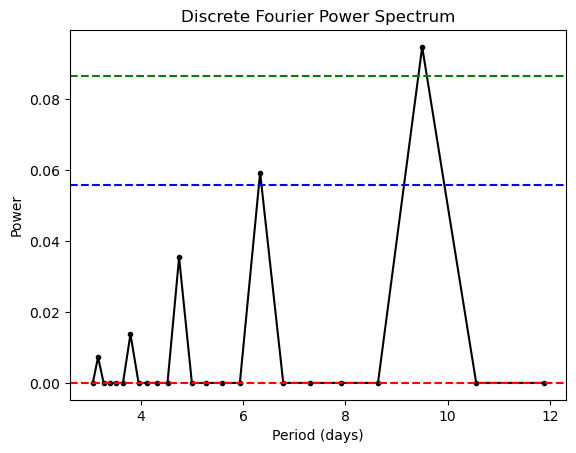

In [7]:
plt.plot(filtered_periods, filtered_magnitude, ".-", color='k')

# Plot significance level lines
plt.axhline(y=thresholds_DFT[0], color='g', linestyle='--', label='1% Significance Level')
plt.axhline(y=thresholds_DFT[1], color='b', linestyle='--', label='5% Significance Level')
plt.axhline(y=thresholds_DFT[2], color='r', linestyle='--', label='32% Significance Level')

plt.xlabel("Period (days)")
plt.ylabel("Power")
plt.title("Discrete Fourier Power Spectrum")
#plt.savefig('DFT_periods', format='eps')

Finding the dominant peak and extracting the results.

In [8]:
if len(filtered_magnitude) > 0:
    dominant_magnitude=np.max(filtered_magnitude)
    dominant_period_idx = np.argmax(filtered_magnitude)
    dominant_period = filtered_periods[dominant_period_idx]
    if dominant_magnitude >=thresholds_DFT[0]:
        print("The dominant period is" ,dominant_period,"days, and is detected with 99% confidence.")  
    elif dominant_magnitude >=thresholds_DFT[1] and dominant_magnitude <thresholds_DFT[0]:
        print("The dominant period is" ,dominant_period,"days, and is detected with 95% confidence.")
    elif dominant_magnitude >=thresholds_DFT[2] and dominant_magnitude <thresholds_DFT[1]:
        print("The dominant period is" ,dominant_period,"days, and is detected with %68 confidence.")
    else:
        print("The dominant period is" ,dominant_period,"days, and is detected with less than 68% confidence.")
else:
    print("No significant periods found above the flux change threshold.")
    
# Estimate noise level using the power spectral density (PSD)
noise_level_DFT = np.mean(np.delete(filtered_magnitude, dominant_period_idx))
print("The noise level is: ", noise_level_DFT)

# Calculate Signal-to-Noise Ratio (SNR)
snr_DFT = filtered_magnitude[dominant_period_idx] / noise_level_DFT
print("The signal to noise for the dominant period is: ", round(snr_DFT,2))

The dominant period is 9.5 days, and is detected with 99% confidence.
The noise level is:  0.00503103437372326
The signal to noise for the dominant period is:  18.84


## Lomb-Scargle Periodogram

Implementing the Lomb-Scargle Periodogram (LSP) and setting the minimum and maximum period to search for.

In [9]:
# Define the period search range (in days)
min_period = 3# Minimum period to search for (in days)
max_period = 12.0  # Maximum period to search for (in days)

# Convert the period range to frequency range
min_frequency = 1 / max_period
max_frequency = 1 / min_period

# Define the number of frequency points to evaluate
num_frequencies = 1000000  # Adjust depending on the precision you need
frequencies = np.linspace(min_frequency, max_frequency, num_frequencies) #The range that LS will search for frequencies and the number of steps

# Use Lomb-Scargle to compute the periodogram
ls = LombScargle(JD_filtered, flux_filtered)
frequency, power = ls.autopower(minimum_frequency=min_frequency, maximum_frequency=max_frequency)

# Convert frequency to period (in days)
periods = 1 / frequency

# Normalize the power (optional, to bring it to a comparable scale)
#power /= np.max(power)

Calculate confidence levels of the detected peaks.

In [10]:
# Calculate False Alarm Probabilities (FAP) - Confidence levels
fap_1_percent = ls.false_alarm_level(0.01)  # 1% FAP
fap_5_percent = ls.false_alarm_level(0.05)  # 5% FAP
fap_32_percent = ls.false_alarm_level(0.32)  # 32% FAP

Plotting the Lomb-Scargle Periodogram.

Text(0.5, 1.0, 'Lomb-Scargle Periodogram')

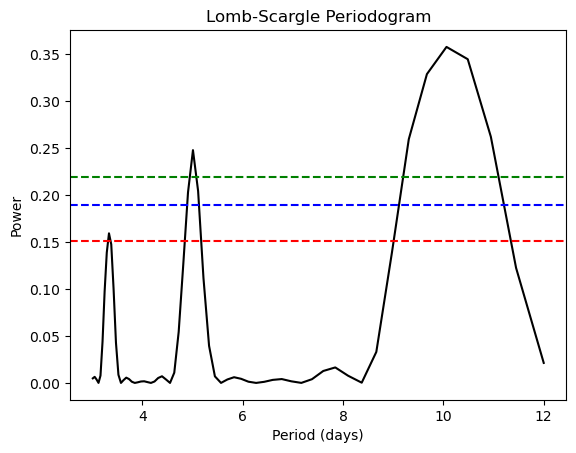

In [11]:
plt.plot(1.0/frequency, power, "-",color="k")

# Plot significance level lines
plt.axhline(y=fap_1_percent, color='g', linestyle='--', label='1% Significance Level')
plt.axhline(y=fap_5_percent, color='b', linestyle='--', label='5% Significance Level')
plt.axhline(y=fap_32_percent, color='r', linestyle='--', label='32% Significance Level')

plt.xlabel("Period (days)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")

Finding the dominant peak and extracting the results.

In [12]:
best_magnitude=np.max(power)
best_period_idx = np.argmax(power)
best_period = 1.0/frequency[best_period_idx]

if best_magnitude >=fap_1_percent:
    print("The most likely period of the exoplanet transit is approximately", round(best_period,2),"days, detected with greater than 99% confidence.")  
elif best_magnitude >=fap_5_percent and best_magnitude <fap_1_percent:
    print("The most likely period of the exoplanet transit is approximately", round(best_period,2),"days, detected with greater than 95% confidence.")
elif best_magnitude >=fap_38_percent and best_magnitude <fap_5_percent:
    print("The most likely period of the exoplanet transit is approximately", round(best_period,2),"days, detected with greater than 68% confidence.")
else:
    print("The most likely period of the exoplanet transit is approximately", round(best_period,2),"days, detected with less than 68% confidence.")

# Estimate noise level using the power spectral density (PSD)
noise_level_LSP = np.mean(np.delete(power, best_period_idx))
print("The noise level is: ", round(noise_level_LSP,2))

# Calculate Signal-to-Noise Ratio (SNR)
snr_LSP = power[best_period_idx] / noise_level_LSP
print("The signal to noise for the most likely period is: ", round(snr_LSP,2))

The most likely period of the exoplanet transit is approximately 10.06 days, detected with greater than 99% confidence.
The noise level is:  0.05
The signal to noise for the most likely period is:  6.56
